# <font color='darkblue'>Setup</font> 

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# <font color='darkblue'>IOD Index</font> 

This data was originall taken from: https://stateoftheocean.osmc.noaa.gov/sur/ind/dmi.php

In [2]:
# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/IOD_index/'
infn = 'dmi_updated_10_07_2020.nc'

ds = xr.open_dataset(path + infn)
ds

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2030)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2020-09-23
Data variables:
    DMI      (WEDCEN2) float64 ...
Attributes:
    history:      FERRET V7.3 (optimized)  7-Oct-20
    Conventions:  CF-1.6

## <font color='lightblue'>All Years</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


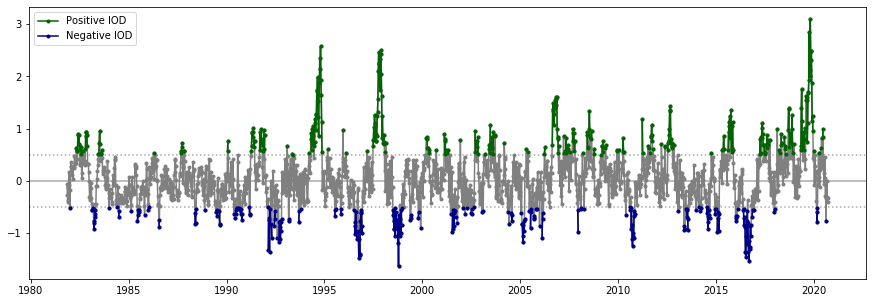

In [3]:
fig = plt.figure(figsize=(15, 5))

time = np.array(ds.DMI.WEDCEN2)
dmi = np.array(ds.DMI)

#pos IOD events
posIOD = np.array(ds.DMI)
posIOD[posIOD<0.5] = np.nan

#neg IOD events
negIOD = np.array(ds.DMI)
negIOD[negIOD>-0.5] = np.nan

#no IOD events
noIOD = np.array(ds.DMI)
noIOD[(noIOD>0.5) | (dmi <-0.5)] = np.nan

plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=0.5, color='darkgray', linestyle=':')
plt.axhline(y=-0.5, color='darkgray', linestyle=':')
no = plt.plot(time,dmi, marker = '.', color='gray')
pos = plt.plot(time,posIOD, marker = '.',color='darkgreen', label="Positive IOD")
neg = plt.plot(time,negIOD, marker = '.', color='darkblue',label = 'Negative IOD')
# plt.xlim(time[20],time[100])

plt.legend()




## <font color='lightblue'>A Specific Year</font> 

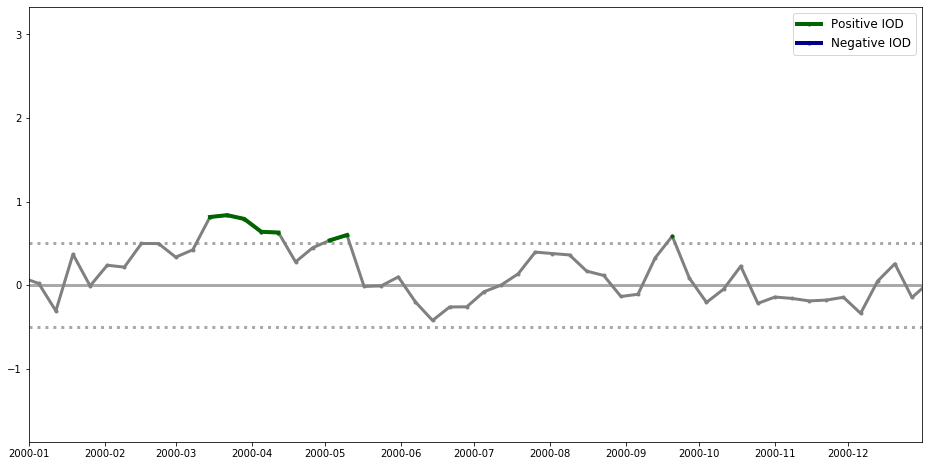

In [4]:
year = '2000'
start_time = year +'-01-01'
end_time = year+'-12-31'

fig = plt.figure(figsize=(16, 8))

time = np.array(ds.DMI.WEDCEN2)
dmi = np.array(ds.DMI)

#pos IOD events
posIOD = np.array(ds.DMI)
posIOD[posIOD<0.5] = np.nan

#neg IOD events
negIOD = np.array(ds.DMI)
negIOD[negIOD>-0.5] = np.nan

#no IOD events
noIOD = np.array(ds.DMI)
noIOD[(noIOD>0.5) | (dmi <-0.5)] = np.nan

plt.axhline(y=0, color='darkgray', linestyle='-', linewidth = 3)
plt.axhline(y=0.5, color='darkgray', linestyle=':', linewidth = 3)
plt.axhline(y=-0.5, color='darkgray', linestyle=':', linewidth = 3)
no = plt.plot(time,dmi, marker = '.', color='gray', linewidth = 3)
pos = plt.plot(time,posIOD, marker = '.',color='darkgreen', linewidth = 4,label="Positive IOD")
neg = plt.plot(time,negIOD, marker = '.', color='darkblue', linewidth = 4,label = 'Negative IOD')
plt.xlim(start_time, end_time)
# plt.ylim(-2,2)

plt.rcParams.update({'font.size': 12})
plt.legend()






### The three years i chose

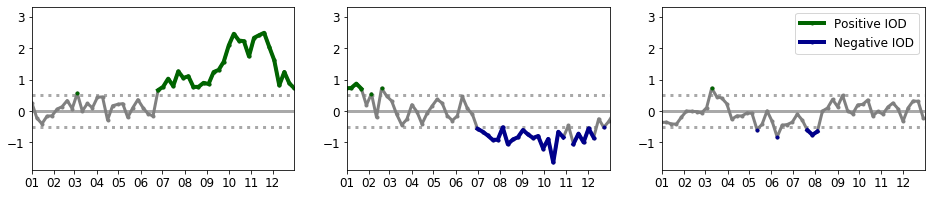

In [5]:
# create list of integer years
years = list(['1997','1998','2004'])

fig = plt.figure(figsize=(16, 3))

for ii,year in enumerate(years):
    # Create time slice from dates
    start_time = year +'-01-01'
    end_time = year+'-12-31'

    time = np.array(ds.DMI.WEDCEN2)
    dmi = np.array(ds.DMI)

    #pos IOD events
    posIOD = np.array(ds.DMI)
    posIOD[posIOD<0.5] = np.nan

    #neg IOD events
    negIOD = np.array(ds.DMI)
    negIOD[negIOD>-0.5] = np.nan

    #no IOD events
    noIOD = np.array(ds.DMI)
    noIOD[(noIOD>0.5) | (dmi <-0.5)] = np.nan

    ax = fig.add_subplot(1,3,ii+1)
    
    ax.axhline(y=0, color='darkgray', linestyle='-', linewidth = 3)
    ax.axhline(y=0.5, color='darkgray', linestyle=':', linewidth = 3)
    ax.axhline(y=-0.5, color='darkgray', linestyle=':', linewidth = 3)
    no = ax.plot(time,dmi, marker = '.', color='gray', linewidth = 3)
    pos = ax.plot(time,posIOD, marker = '.',color='darkgreen', linewidth = 4,label="Positive IOD")
    neg = ax.plot(time,negIOD, marker = '.', color='darkblue', linewidth = 4,label = 'Negative IOD')
    plt.xlim(start_time, end_time)
    ax.set_xticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])

plt.rcParams.update({'font.size': 12})
plt.legend()






# <font color='darkblue'>Hovmueller Plots</font> 

In [6]:
# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/ssh_AVISO/'
infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018.nc'

ds = xr.open_dataset(path + infn)
#print(ds.keys())

# Subset ------------------------------------------------#

# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(30, 120) # bounds inclusive

# Get data, selecting lat/lon slice
sla = ds['sla'].sel(latitude=lat_slice,longitude=lon_slice)
lat = sla.latitude.values
lon = sla.longitude.values

# Create Grid -------------------------------------------#

# convert to a grid
[lon_grid, lat_grid] = np.meshgrid(lon,lat)

## <font color='lightblue'>Find Coastal Boxes</font> 

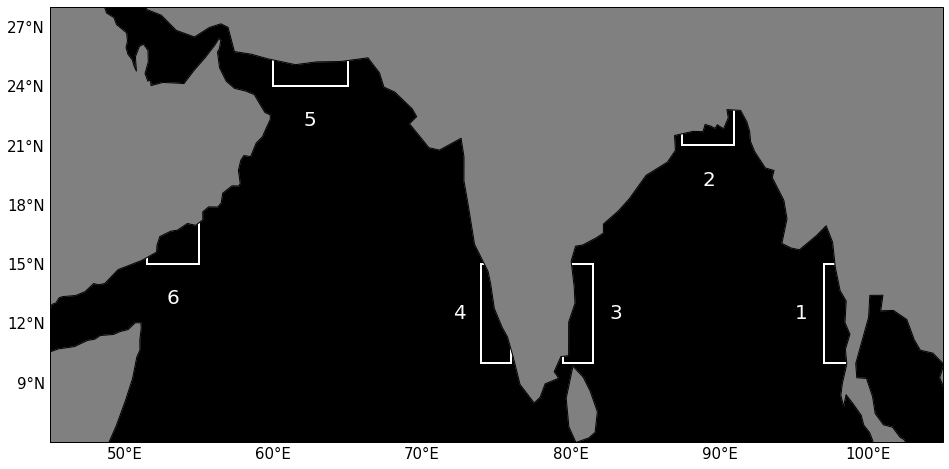

In [7]:
# [lonmin, lonmax, latmin, latmax]

bounds = [45,105,6,28]

def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
# Start figure
fig = plt.figure(figsize=(16, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)

bboxes = [[97,99,10,15],
         [87.5,91,21,23],
         [79.5,81.5,10,15],
         [74,76,10,15],
         [60,65,24,26],
         [51.5,55,15,17.5]]

for ii, box in enumerate(bboxes): 
    p = Rectangle(
    (box[0], box[2]), box[1]-box[0], box[3]-box[2],
    linewidth=2,fill=False,color='white')

    ax.add_patch(p)
    rx, ry = p.get_xy()
    cx = rx + p.get_width()/2.0
    cy = ry + p.get_height()/2.0
    
#     ax.text(0.5*(box[0]+box[1]), 0.5*(box[2]+box[3]), str(ii+1),
#         horizontalalignment='center',
#         verticalalignment='center',
#         fontsize=20, color='purple')
    if (ii == 0) | (ii == 3):
        ax.text(box[0]-1.5, 0.5*(box[2]+box[3]), str(ii+1),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='white')
    elif (ii == 1) | (ii == 4) | (ii == 5):
        ax.text(0.5*(box[0]+box[1]), box[2]-1.75, str(ii+1),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='white')
    else:
        ax.text(box[1]+1.5, 0.5*(box[2]+box[3]), str(ii+1),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='white')

## <font color='lightblue'>Hovmueller for Boxes</font> 

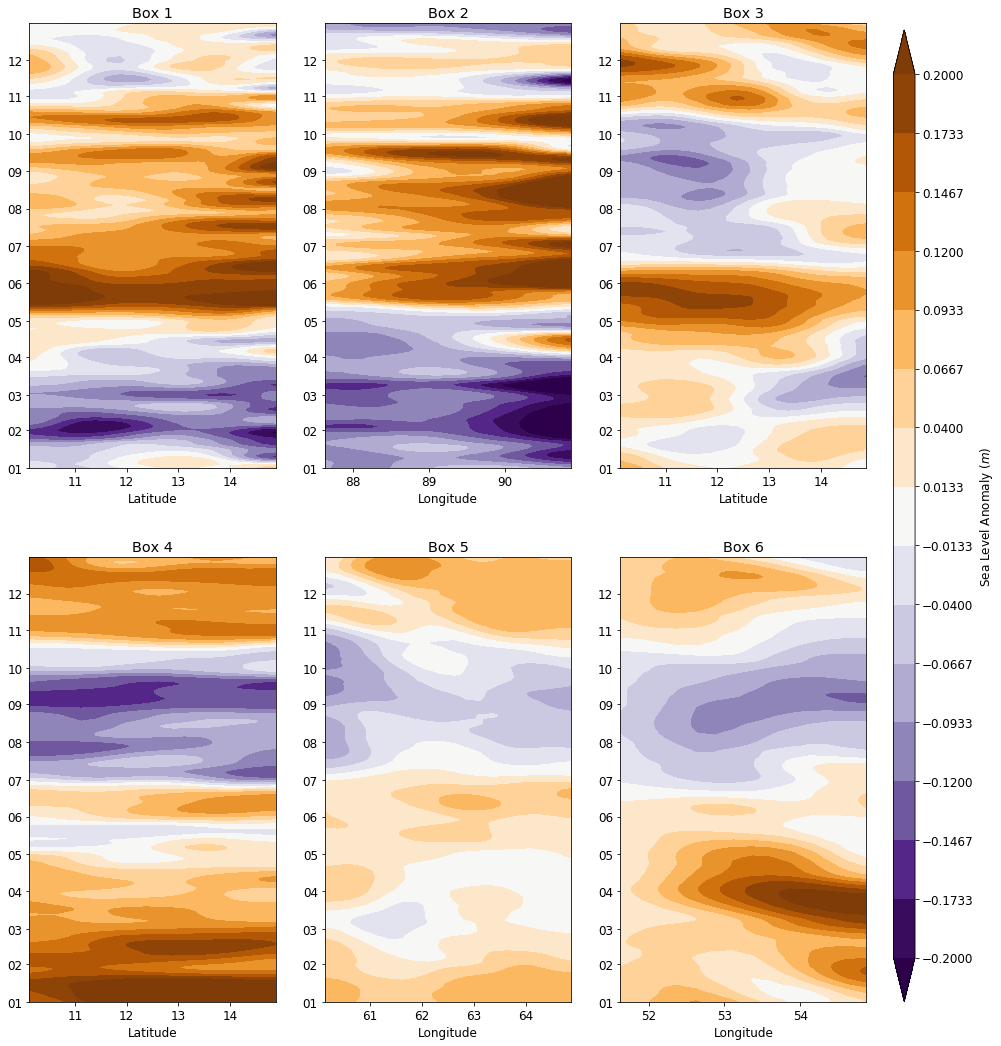

In [8]:
# Create time slice from dates
year = '2004'
start_time = year +'-01-01'
end_time = year+'-12-31'

fig = plt.figure(figsize=(15, 18))

for ii, box in enumerate(bboxes): 

    # Create slice variables subset domain
    time_slice = slice(start_time, end_time)
    lat_slice = slice(box[2], box[3])
    lon_slice = slice(box[0], box[1])

    # Get data, selecting time, level, lat/lon slice
    data = sla.sel(time=time_slice,latitude=lat_slice,
                         longitude=lon_slice)

    cmin = -0.2
    cmax = 0.2
    no_levels = 16
    
    
    levels = np.linspace(cmin, cmax, no_levels)
    
    if (ii == 1) | (ii == 4)| (ii == 5):
        # Compute weights and take weighted average over latitude dimension
        weights = np.cos(np.deg2rad(data.latitude.values))
        avg_data = (data * weights[:, None]).sum(dim='latitude') / np.sum(weights)

        #smoothed data
        sm_data = xr.DataArray(gaussian_filter(avg_data, sigma=1.5),coords = [avg_data.time,avg_data.longitude])

        # Get times and make array of datetime objects
        vtimes = data.time.values.astype('datetime64[ms]').astype('O')

        # Specify longitude values for chosen domain
        lons = data.longitude.values
        lats = data.latitude.values

        ax = fig.add_subplot(2,3,ii+1)

        # Plot of chosen variable averaged over latitude
        cf = ax.contourf(lons, vtimes,sm_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
        ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
        plt.xlabel('Longitude')
        plt.title('Box ' + str(ii+1))
        cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
    else:
        # Compute weights and take weighted average over latitude dimension
        avg_data = data.mean(dim='longitude')

        #smoothed data
        sm_data = xr.DataArray(gaussian_filter(avg_data, sigma=1.5),coords = [avg_data.time,avg_data.latitude])

        # Get times and make array of datetime objects
        vtimes = data.time.values.astype('datetime64[ms]').astype('O')

        # Specify longitude values for chosen domain
        lons = data.longitude.values
        lats = data.latitude.values

        ax = fig.add_subplot(2,3,ii+1)

        # Plot of chosen variable averaged over latitude
        cf = ax.contourf(lats, vtimes, sm_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
        ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
        plt.xlabel('Latitude')
        plt.title('Box ' + str(ii+1))
        cf.set_clim(cmin, cmax)
 
cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04,ticks=levels, label='Sea Level Anomaly ($m$)')
# cbar.set_label('Sea Level Anomaly ($m$)')



## <font color='lightblue'>Hovmueller for Equatorial Box All Years</font> 

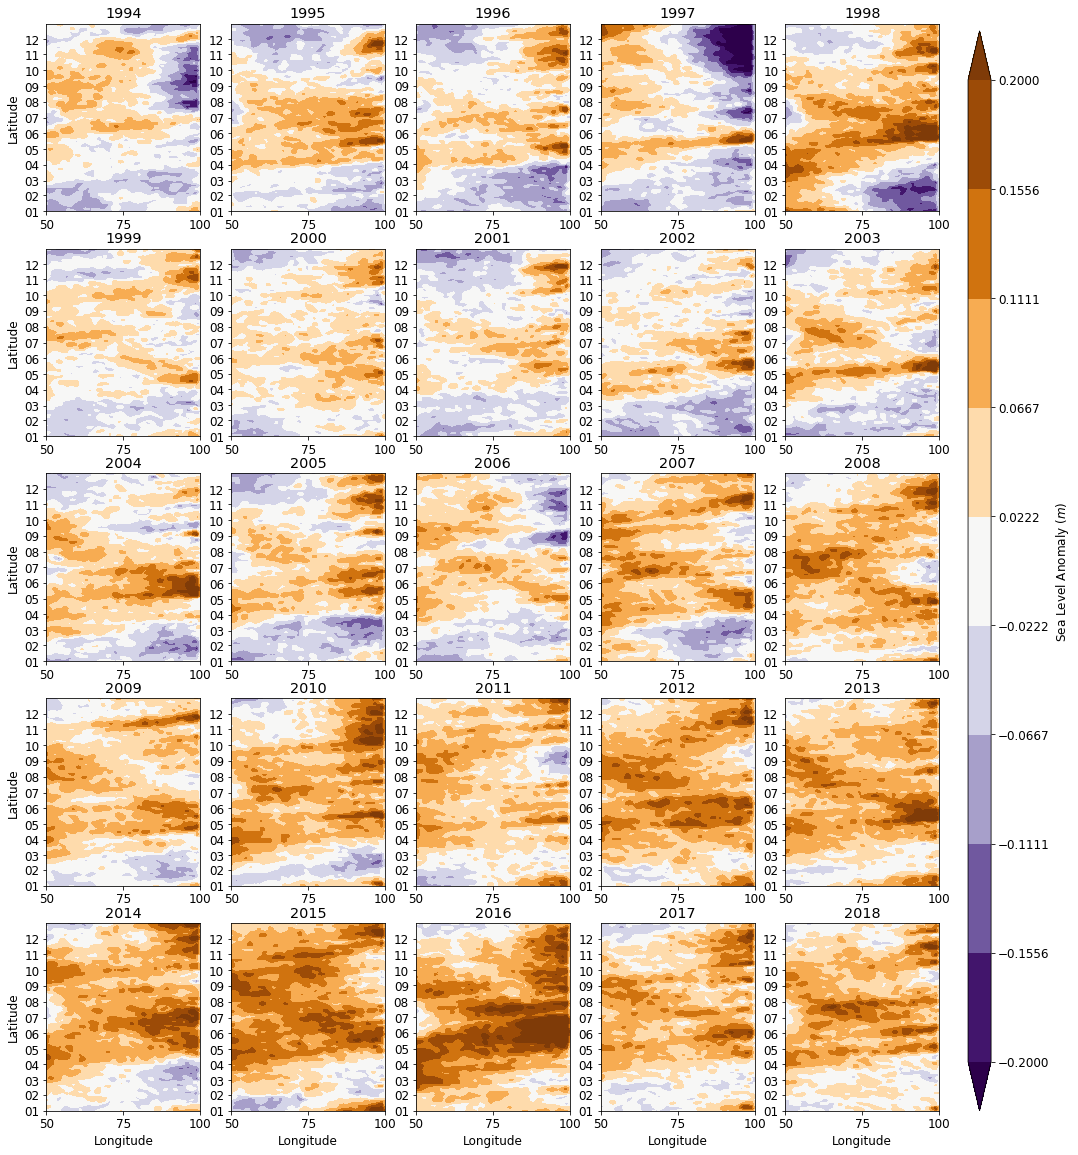

In [9]:
# create list of integer years
years = list(range(1994,2019))

# maps to strings
years = map(str,years)

# convert back to list
years = list(years)

ebox = [50,100,-1,1]

cmin = -0.2
cmax = 0.2

fig = plt.figure(figsize=(16, 20))

for ii,year in enumerate(years):
    # Create time slice from dates
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    
    # Create slice variables subset domain
    time_slice = slice(start_time, end_time)
    lat_slice = slice(ebox[2], ebox[3])
    lon_slice = slice(ebox[0], ebox[1])

    # Get data, selecting time, level, lat/lon slice
    data = sla.sel(time=time_slice,latitude=lat_slice,
                         longitude=lon_slice)

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Compute weights and take weighted average over latitude dimension
    weights = np.cos(np.deg2rad(data.latitude.values))
    avg_data = (data * weights[:, None]).sum(dim='latitude') / np.sum(weights)

    #smoothed data
#     sm_data = xr.DataArray(gaussian_filter(avg_data, sigma=0.5),coords = [avg_data.time,avg_data.longitude])

    # Get times and make array of datetime objects
    vtimes = data.time.values.astype('datetime64[ms]').astype('O')

    # Specify longitude values for chosen domain
    lons = data.longitude.values
    lats = data.latitude.values

    ax = fig.add_subplot(5,5,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(lons, vtimes,avg_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    if ii >= 20:
        plt.xlabel('Longitude')
    if np.mod(ii,5) == 0:
        plt.ylabel('Latitude')
        
    plt.title(year)
    ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
    ax.set_xticks([50,75,100])
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')



## <font color='lightblue'>Hovmueller for Equatorial Box Specific Year</font> 

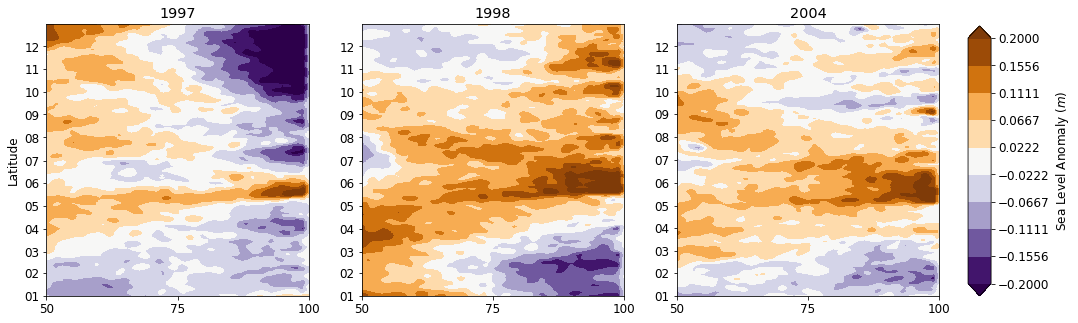

In [10]:
# create list of integer years
years = list(['1997','1998','2004'])

ebox = [50,100,-1,1]

cmin = -0.2
cmax = 0.2

fig = plt.figure(figsize=(16, 5))

for ii,year in enumerate(years):
    # Create time slice from dates
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    
    # Create slice variables subset domain
    time_slice = slice(start_time, end_time)
    lat_slice = slice(ebox[2], ebox[3])
    lon_slice = slice(ebox[0], ebox[1])

    # Get data, selecting time, level, lat/lon slice
    data = sla.sel(time=time_slice,latitude=lat_slice,
                         longitude=lon_slice)

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Compute weights and take weighted average over latitude dimension
    weights = np.cos(np.deg2rad(data.latitude.values))
    avg_data = (data * weights[:, None]).sum(dim='latitude') / np.sum(weights)

    #smoothed data
#     sm_data = xr.DataArray(gaussian_filter(avg_data, sigma=0.5),coords = [avg_data.time,avg_data.longitude])

    # Get times and make array of datetime objects
    vtimes = data.time.values.astype('datetime64[ms]').astype('O')

    # Specify longitude values for chosen domain
    lons = data.longitude.values
    lats = data.latitude.values

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(lons, vtimes,avg_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    if ii >= 20:
        plt.xlabel('Longitude')
    if np.mod(ii,5) == 0:
        plt.ylabel('Latitude')
        
    plt.title(year)
    ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
    ax.set_xticks([50,75,100])
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')




In [11]:
avg_data.shape

(366, 200)

## For entire coastline

In [240]:
def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)



In [241]:
latinds, loninds = find_coast(np.array(sla[0,:,:]))

In [242]:
# manually remove some points

# remove lower boundary ( about 10N)
loninds = loninds[latinds>120]
latinds = latinds[latinds>120]

BoB_latinds = latinds
BoB_loninds = loninds

BoB_latinds = BoB_latinds[(BoB_loninds>195) & (BoB_loninds<276)]
BoB_loninds = BoB_loninds[(BoB_loninds>195) & (BoB_loninds<276)]

# sort from right to left
# sta_lons = lon[BoB_loninds]
# sta_lats = lat[BoB_latinds]

# for ii in range(BoB_loninds.shape[0]):
#     indlon = (sta_lons[ii+1] == sta_lons[ii]+0.25) & (sta_lats[ii+1] == sta_lats[ii]) 
#     indlat = (sta_lons[ii+1] == sta_lons[ii]) & (sta_lats[ii+1] == sta_lats[ii]+0.25) 
#     ind = (indlon) | (indlat)

pos = [(BoB_loninds[i], BoB_latinds[i]) for i in range(0, len(BoB_loninds))]
pos = sorted(pos, key=lambda tup: -tup[0])
sta_lons = []
sta_lats = []

Output = {}
for x, y in pos: 
    if x in Output: 
        Output[x].append((x, y)) 
    else: 
        Output[x] = [(x, y)]
# print(Output) 

sta = []
for y in Output:
    tuples = Output[y]
    #sort
    tuples = sorted(tuples, key=lambda tup: tup[1])
    lon_temp, lat_temp = zip(*tuples)
    sta_lons.extend(list(lon_temp))
    sta_lats.extend(list(lat_temp))

# print(list(Output.values()))
# sort_lons = np.sort(a.view('i8,i8,i8'), order=['f1'], axis=0).view(np.int)    
# AS_latinds = latinds
# AS_loninds = loninds

# AS_latinds = AS_latinds[(AS_loninds>119) & (AS_loninds<195)]
# AS_loninds = AS_loninds[(AS_loninds>119) & (AS_loninds<195)]

# EQ_latinds
# EQ_loninds

In [277]:
# find based on radius
zipped_lists = zip(BoB_loninds, BoB_latinds)
sorted_pairs = sorted(zipped_lists, reverse=True)

# sort by lon
tuples = zip(*sorted_pairs)
lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

# pick first point
sta_zero = (274,121) # 98.625, 10.375

pos = []
curr_sta = []
rem_sta = sorted_pairs
for i in range(len(lon_list)):
    if i == 0:
        curr_sta.append(sta_zero)
        prev_sta = sta_zero
    else:
        prev_sta = curr_sta[i-1]

    for j,(lo, la) in enumerate(rem_sta):
        next_sta = (rem_sta[j])
        
        diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))

        # check diagonals first
        if (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
            curr_sta.append(next_sta)
            rem_sta.remove(next_sta) 
            break
            
        # then check uplr
        elif(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
            curr_sta.append(next_sta)
            rem_sta.remove(next_sta) 
            break

BoB_sta_lonind,BoB_sta_latind  = map(np.array, zip(*curr_sta))
BoB_sta_lonind,BoB_sta_latind

(array([274, 274, 274, 274, 274, 275, 275, 274, 274, 274, 274, 274, 273,
        273, 272, 272, 271, 271, 271, 271, 271, 270, 270, 270, 270, 270,
        269, 268, 268, 267, 267, 267, 266, 265, 264, 264, 264, 263, 262,
        261, 260, 259, 258, 257, 256, 257, 257, 257, 258, 258, 257, 257,
        257, 256, 256, 256, 256, 255, 254, 253, 252, 252, 251, 250, 250,
        249, 248, 247, 247, 247, 247, 246, 246, 245, 244, 243, 242, 242,
        241, 240, 239, 238, 237, 236, 236, 235, 234, 234, 233, 232, 231,
        230, 229, 228, 227, 227, 227, 227, 226, 226, 225, 224, 223, 222,
        221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209,
        209, 209, 208, 207, 206, 205, 204, 203, 202, 201, 201, 200, 200,
        200, 200, 200, 200, 200, 201, 201, 201, 201, 200, 200, 199, 199,
        199, 199, 199, 199, 199, 198, 197]),
 array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
      

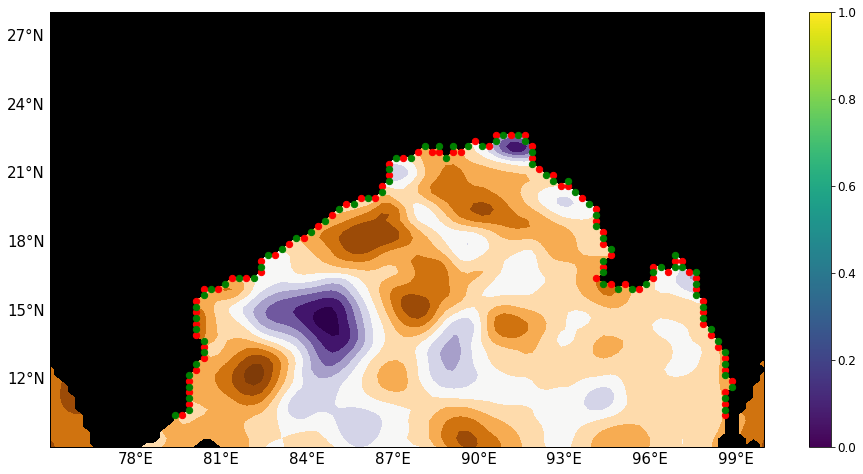

In [273]:
#BoB

bounds = [75,100,9,28]

def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#     ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
#     ax.coastlines(resolution='50m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
cf = ax.contourf(lon, lat,sla[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
ns = len(BoB_sta_lonind)
even = np.arange(0,ns,2)
odd = np.arange(1,ns,2)
plt.scatter(lon[BoB_sta_lonind[even]],lat[BoB_sta_latind[even]],s = 160,c='r',marker = '.')
plt.scatter(lon[BoB_sta_lonind[odd]],lat[BoB_sta_latind[odd]],s = 160,c='g',marker = '.')
# plt.scatter(lon[BoB_sta_lonind],lat[BoB_sta_latind],s = 160,c=np.arange(ns),marker = '.')
# plt.scatter(lon[AS_loninds],lat[AS_latinds],s = 60,c='b',marker = '.')
plt.colorbar()

## Hovmuleler Coastline

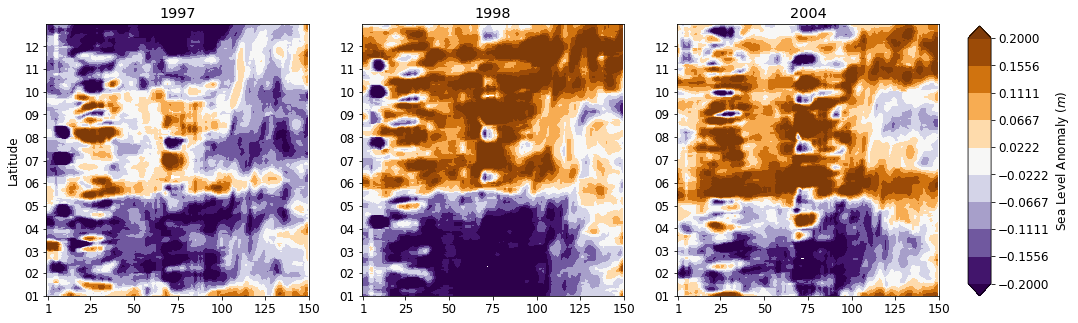

In [281]:
# create list of integer years
years = list(['1997','1998','2004'])

cmin = -0.2
cmax = 0.2

fig = plt.figure(figsize=(16, 5))

for ii,year in enumerate(years):
    # Create time slice from dates
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    
    # Create slice variables subset domain
    time_slice = slice(start_time, end_time)

    time_data = sla.sel(time=time_slice)
    
    # Get times and make array of datetime objects
    vtimes = time_data.time.values.astype('datetime64[ms]').astype('O')
    
    data = np.zeros([vtimes.shape[0],BoB_sta_lonind.shape[0]])
    for jj in range(BoB_sta_lonind.shape[0]):
        data[:,jj] = time_data[:,BoB_sta_latind[jj],BoB_sta_lonind[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(BoB_sta_lonind))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    if ii >= 20:
        plt.xlabel('Longitude')
    if np.mod(ii,5) == 0:
        plt.ylabel('Latitude')
        
    plt.title(year)
    ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
    ax.set_xticks([1,25,50,75,100,125,150])
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

In [ ]:
## Rempve the seasonal cycle and find the average over pos iod years, neg iod years, and no iod years and plot

In [ ]:
# create list of integer years
years = list(['1997','1998','2004'])

cmin = -0.2
cmax = 0.2

fig = plt.figure(figsize=(16, 5))

for ii,year in enumerate(years):
    # Create time slice from dates
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    
    # Create slice variables subset domain
    time_slice = slice(start_time, end_time)

    time_data = sla.sel(time=time_slice)
    
    # Get times and make array of datetime objects
    vtimes = time_data.time.values.astype('datetime64[ms]').astype('O')
    
    data = np.zeros([vtimes.shape[0],BoB_latinds.shape[0]])
    for jj in range(BoB_latinds.shape[0]):
        data[:,jj] = time_data[:,BoB_latinds[jj],BoB_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(BoB_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    if ii >= 20:
        plt.xlabel('Longitude')
    if np.mod(ii,5) == 0:
        plt.ylabel('Latitude')
        
    plt.title(year)
    ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
    ax.set_xticks([1,25,50,75,100,125,150])
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

In [ ]:
BoB_latinds[0]

In [ ]:
BoB_loninds[0]

In [ ]:
sla[0,121,197]

In [ ]:
sla[0,BoB_latinds[10],BoB_loninds[0]]

In [ ]:

a = np.arange(32).reshape((8, 4))
a=np.array(a,dtype = float)
a[2:, 2:] = np.nan
a[1,2]=np.nan
a[3,1]=np.nan
a[4,:2]=np.nan
a[5,1]=np.nan
a[7,1]=np.nan
a

latinds,loninds =find_coast(a)

x = np.arange(a.shape[1])
y = np.arange(a.shape[0])

xx,yy = np.meshgrid(x,y)
plot_a = np.zeros_like(a)
plot_a[np.isnan(a)] = np.nan

plt.scatter(xx.flatten(),yy.flatten(),s = 75,c = plot_a.flatten(),marker ='o')
plt.scatter(xx[latinds,loninds],yy[latinds,loninds],s = 60,c='y',marker = '.')

In [ ]:
row = 3
col = 2


In [ ]:
a[row-1:row+2,col-1:col+2]

In [ ]:
min(a.shape[0],row+2)

In [ ]:
row+2

In [ ]:
ds.sla[0,:,:].shape

In [ ]:
# sta_lons = []
# sta_lats = []
# keylist = list(Output.keys())
# for i, (y,x) in enumerate(Output.items()):
# #     print(i)
#     tuples = Output[y]
#     #sort
#     tuples = sorted(tuples, key=lambda tup: tup[1])
#     lon_temp, lat_temp = zip(*tuples)
#     print(i,'curr',lon_temp, lat_temp)
#     if i == 0:
#         sta_lons.extend(list(lon_temp))
#         sta_lats.extend(list(lat_temp))
#     else:
#         prev_tuples = Output[keylist[i-1]]
#         #sort
#         prev_tuples = sorted(prev_tuples, key=lambda tup: tup[1])
#         prev_lon, prev_lat = zip(*prev_tuples)
#         print(i,'prev',prev_lon, prev_lat,np.min(prev_lat))
    
# sta_lons,sta_lats

In [ ]:
# # coarsen to 1 degree boxes
# def latlon_coarsen(invar,lat,lon,binwidth):
#     import numpy as np
    
#     # create a pandas dataframe
#     df = pd.DataFrame(dict(
#             invar = np.array(invar),
#             lat= np.array(lat),
#             lon= np.array(lon)
#         ))
    

#     # create 1 degree bins
#     latedges = np.arange(lat.min()-(binwidth/2),lat.max()+(binwidth/2),binwidth)
#     lat_inds = list(range(len(latedges)-1))

#     lonedges = np.arange(lon.min()-(binwidth/2),lon.max()+(binwidth/2),binwidth)
#     lon_inds = list(range(len(lonedges)-1))

#     latbins = latedges[1:]-(binwidth/2)
#     lonbins = lonedges[1:]-(binwidth/2)

#     df['latedges'] = pd.cut(lat, latedges)
#     df['lonedges'] = pd.cut(lon, lonedges)
#     df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
#     df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
#     df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
#     grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

#     invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
#     invar_BINNED[:] = np.nan

#     invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
#     invar_binned_ave[:] = np.nan


#     #extract the data for each group
#     for name, group in grouped:
#         i = np.array(group.latbins_ind)
#         j = np.array(group.lonbins_ind)

#         invar_BINNED[i[0],j[0]] = group.invar

#         invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)
        
#     # create pcolormesh lat/lon vals
    
#     # extend longitude by 2
#     lon_extend = np.zeros(lonbins.size+2)
#     # fill in internal values
#     lon_extend[1:-1] = lonbins # fill up with original values
#     # fill in extra endpoints
#     lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
#     lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
#     # calculate the midpoints
#     lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

#     # extend latitude by 2
#     lat_extend = np.zeros(latbins.size+2)
#     # fill in internal values
#     lat_extend[1:-1] = latbins
#     # fill in extra endpoints
#     lat_extend[0] = latbins[0]-np.diff(latbins)[0]
#     lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
#     # calculate the midpoints
#     lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))
    

#     return(np.array(invar_binned_ave,dtype = float), 
#            lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)



In [ ]:
# xx,yy = np.meshgrid(lon,lat)
# _,lonbins,latbins,_,_ =latlon_coarsen(np.array(sla[tt,:,:]).ravel(),xx.ravel(),yy.ravel(),1)

# sla_1deg=np.zeros([sla.shape[0],len(latbins),len(lonbins)])

# for tt in range(len(sla.time)):
#     sla_1deg[tt,:,:],lonbins,latbins,_,_ = latlon_coarsen(np.array(sla[tt,:,:]).ravel(),xx.ravel(),yy.ravel(),1)

